#Evaluate ACCESS-OM2-01 IAF Properties in Denman Region
#https://cchdo.ucsd.edu/search?bbox=105,-90,115,-50

see aidans code here: https://nbviewer.org/gist/aidanheerdegen/aa816ac249884b97e8d82251b0fd4d41
and rendered here: https://gist.github.com/aidanheerdegen/aa816ac249884b97e8d82251b0fd4d41

In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cartopy.crs as ccrs
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath

import cmocean.cm as cmocean
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pyproj import Proj, transform

In [2]:
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:38459 Dashboard: /proxy/40477/status,Cluster Workers: 8 Cores: 8 Memory: 200.00 GiB


In [3]:
def change_lon_space(ds, grid):
    if grid == 'u':
        #ds = ds.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
        
        #for 0-360
        ds['_lon_adj'] = xr.where(ds['xu_ocean'] < 0, ds['xu_ocean'] + 360, ds['xu_ocean'])
        #do this line as well if want to switch to -180 to 180
        ds['_lon_adj'] = xr.where(ds['_lon_adj'] >180, ds['_lon_adj'] - 360, ds['_lon_adj'])

        ds = ds.swap_dims({'xu_ocean': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('xu_ocean')
        ds = ds.rename({'_lon_adj': 'xu_ocean'})
    elif grid == 't':
        #ds = ds.rename(({'xt_ocean':'lon', 'yt_ocean':'lat'}))
        
        #for 0-360
        ds['_lon_adj'] = xr.where(ds['xt_ocean'] < 0, ds['xt_ocean'] + 360, ds['xt_ocean'])
        #do this line as well if want to switch to -180 to 180
        ds['_lon_adj'] = xr.where(ds['_lon_adj'] >180, ds['_lon_adj'] - 360, ds['_lon_adj'])
        
        ds = ds.swap_dims({'xt_ocean': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('xt_ocean')
        ds = ds.rename({'_lon_adj': 'xt_ocean'})
    return ds

In [4]:
bedbathy=xr.open_mfdataset('/g/data/v45/pas561/bedmachineant/bathy_om2.nc',engine='netcdf4',decode_times=False)
#bedbathy

In [5]:
bedbathy

<xarray.Dataset>
Dimensions:    (lat: 696, lon: 3600)
Coordinates:
  * lon        (lon) float64 -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * lat        (lat) float64 -81.11 -81.07 -81.02 ... -48.19 -48.13 -48.06
Data variables:
    mapping    (lat, lon) |S8 dask.array<chunksize=(696, 3600), meta=np.ndarray>
    mask       (lat, lon) float64 dask.array<chunksize=(696, 3600), meta=np.ndarray>
    firn       (lat, lon) float32 dask.array<chunksize=(696, 3600), meta=np.ndarray>
    surface    (lat, lon) float32 dask.array<chunksize=(696, 3600), meta=np.ndarray>
    thickness  (lat, lon) float32 dask.array<chunksize=(696, 3600), meta=np.ndarray>
    bed        (lat, lon) float32 dask.array<chunksize=(696, 3600), meta=np.ndarray>
    errbed     (lat, lon) float32 dask.array<chunksize=(696, 3600), meta=np.ndarray>
    source     (lat, lon) float64 dask.array<chunksize=(696, 3600), meta=np.ndarray>
    geoid      (lat, lon) float64 dask.array<chunksize=(696, 3600), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     15-Jul-2020 (v2.0)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

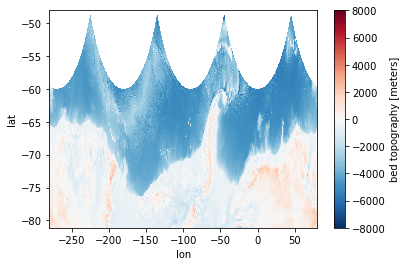

In [6]:
bedbathy.bed.plot.pcolormesh()

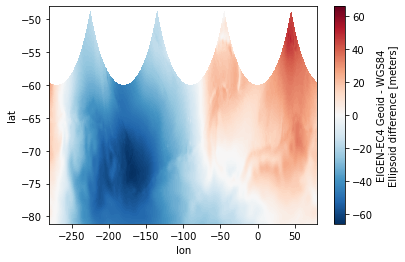

In [7]:
bedbathy.geoid.plot.pcolormesh()

In [8]:
#see also doc in /g/data/v45/pas561/bedmachineant/ All heights are referenced to mean sea level (using the geoid EIGEN-6C4). To convert the heights to heightsreferenced to the WGS84 ellipsoid, simply add the geoid height. 
#Note that we re-sort the y-index to run from negative to positive values#bedbathy
bb=bedbathy.bed.load()+bedbathy.geoid.load()
bb

<xarray.DataArray (lat: 696, lon: 3600)>
array([[ 997.19189453, 1175.90771484, 1264.4465332 , ..., 1121.69262695,
         990.78588867,  950.73608398],
       [ 852.19384766,  905.04516602,  991.81542969, ..., 1084.73486328,
         947.35009766,  851.32275391],
       [ 743.62524414,  735.22241211,  698.01342773, ...,  921.97705078,
         826.55712891,  782.45336914],
       ...,
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]])
Coordinates:
  * lon      (lon) float64 -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * lat      (lat) float64 -81.11 -81.07 -81.02 -80.98 ... -48.19 -48.13 -48.06

In [13]:
#denman region
#bb.sel(lat=slice(-68,-60)).sel(lon=slice(-275,-245)).plot.pcolormesh() #

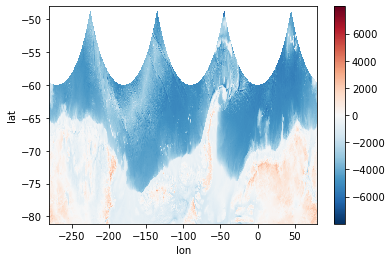

In [14]:
bb.plot.pcolormesh()

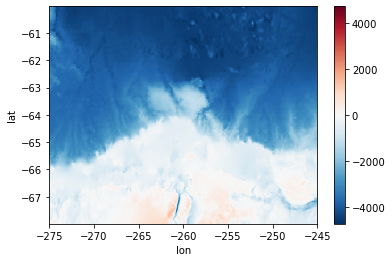

In [15]:
#denman region
bb.sel(lat=slice(-68,-60)).sel(lon=slice(-275,-245)).plot.pcolormesh() #

In [17]:
bb=bb.rename({'lon': 'xt_ocean','lat': 'yt_ocean'})
bb

<xarray.DataArray (yt_ocean: 696, xt_ocean: 3600)>
array([[ 997.19189453, 1175.90771484, 1264.4465332 , ..., 1121.69262695,
         990.78588867,  950.73608398],
       [ 852.19384766,  905.04516602,  991.81542969, ..., 1084.73486328,
         947.35009766,  851.32275391],
       [ 743.62524414,  735.22241211,  698.01342773, ...,  921.97705078,
         826.55712891,  782.45336914],
       ...,
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]])
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -48.19 -48.13 -48.06

In [18]:
bb = change_lon_space(bb, 't')

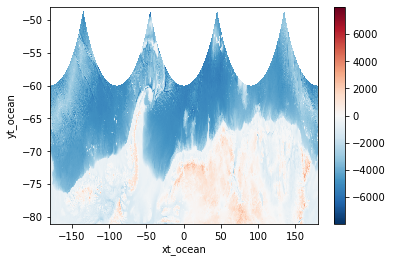

In [37]:
bb.plot.pcolormesh()

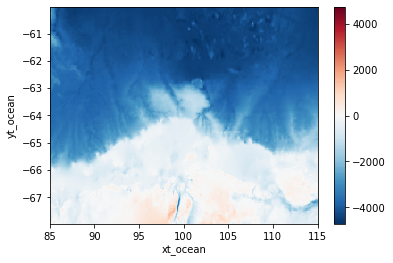

In [29]:
#denman region
bb.sel(yt_ocean=slice(-68,-60)).sel(xt_ocean=slice(85,115)).plot.pcolormesh()

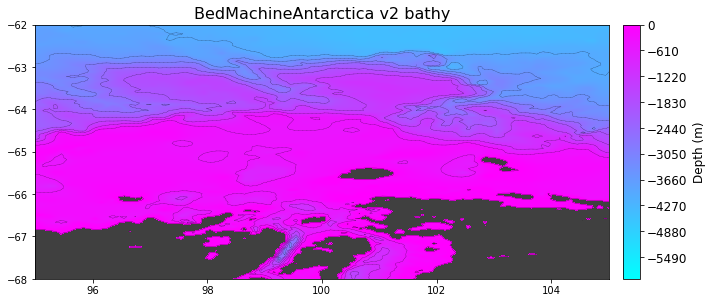

In [24]:
#plot using new lat lon coords .... stalls out
clev = np.arange(-6000,10,10)
clev2 = np.arange(-6000,500,500)
fontsize=12

plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.gca().patch.set_color('.25')
#p1=plt.pcolormesh(bb.x,bb.y,bb,vmin=-1500, vmax=0,cmap=plt.cm.cool)
p1=plt.contourf(bb.xt_ocean,bb.yt_ocean,bb,levels=clev,cmap=plt.cm.cool)
plt.contour(bb.xt_ocean,bb.yt_ocean,bb,levels=clev2,colors='k',linewidths=0.25)
plt.ylim([-68,-62])
plt.xlim([95,105])
plt.title('BedMachineAntarctica v2 bathy',fontsize = 16)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Depth (m)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()

In [25]:
clev2

array([-6000, -5500, -5000, -4500, -4000, -3500, -3000, -2500, -2000,
       -1500, -1000,  -500,     0])

#Plot ACCCESS-OM2-01 model bathymetry

In [26]:

# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

In [27]:
# topography data for plotting:
lat_slice  = slice(-82,-50.04) #-50.04-

ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
#land_mask = np.squeeze(ht.values)*0
#land_mask[np.isnan(land_mask)] = 1
#land_mask = np.where(land_mask==1,land_mask,np.nan)

In [28]:
ht = change_lon_space(ht, 't')


In [30]:
np.nanmax(ht.values)

5808.6567

In [30]:
var1=-ht.sel(yt_ocean=slice(-68,-60)).sel(xt_ocean=slice(85,115)).load()
var2=bb.sel(yt_ocean=slice(-68,-60)).sel(xt_ocean=slice(85,115)).load()
var=var1-var2
var

<xarray.DataArray (yt_ocean: 179, xt_ocean: 300)>
array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       ...,
       [-5.93261719e-02, -2.43115234e+01, -2.39506836e+01, ...,
         2.28632812e+01,  2.13291016e+01,  1.86660156e+01],
       [ 2.26738281e+01, -2.83132324e+01, -2.26997070e+01, ...,
         1.23105469e+01,  2.35751953e+01,  1.73115234e+01],
       [-6.32709961e+01, -4.88339844e+01, -2.34997559e+01, ...,
         1.13735352e+01,  2.02631836e+01,  2.59555664e+01]])
Coordinates:
  * yt_ocean  (yt_ocean) float64 -67.97 -67.93 -67.89 ... -60.15 -60.1 -60.05
    geolon_t  (yt_ocean, xt_ocean) float32 nan nan nan ... -245.2 -245.1 -245.1
    geolat_t  (yt_ocean, xt_ocean) float32 nan nan nan ... -60.05 -60.05 -60.05
  * xt_ocean  (xt_ocean) float64 85.05 85.15 85.25 85.35 ... 114.8 114.9 115.0

In [32]:
bb

<xarray.DataArray (yt_ocean: 696, xt_ocean: 3600)>
array([[-555.02893066, -558.8684082 , -563.66333008, ..., -551.05319214,
        -550.73822021, -551.71047974],
       [-560.70446777, -565.63421631, -571.51037598, ..., -553.13369751,
        -553.88018799, -555.93121338],
       [-568.38354492, -573.8536377 , -582.64263916, ..., -557.62692261,
        -559.03277588, -561.78717041],
       ...,
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]])
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -48.19 -48.13 -48.06
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0

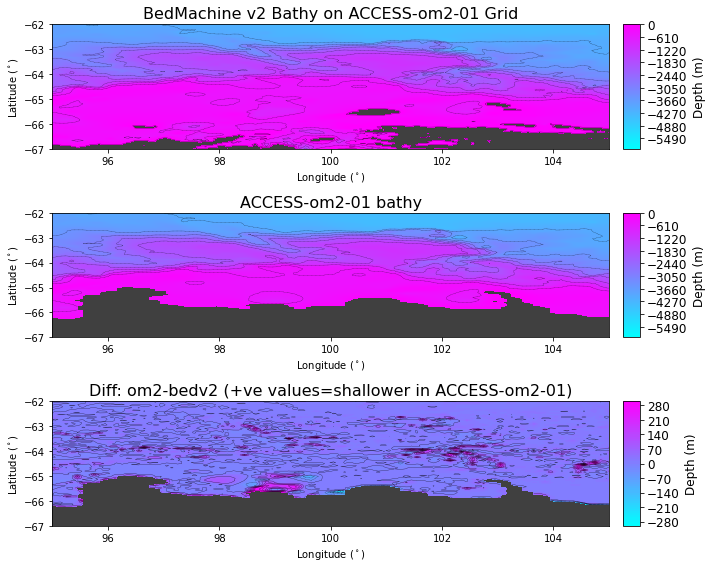

In [42]:
#np.nanmax(ht.values)
clev = np.arange(-6000,10,10)
clev2 = np.arange(-6000,500,500)
fontsize=12

plt.figure(figsize=(10,8))

plt.subplot(3,1,1)
plt.gca().patch.set_color('.25')
#p1=plt.pcolormesh(ht.xt_ocean,ht.yt_ocean,ht,vmin=0, vmax=6000,cmap=plt.cm.cool)
p1=plt.contourf(bb.xt_ocean,bb.yt_ocean,bb,levels=clev,cmap=plt.cm.cool)
plt.contour(bb.xt_ocean,bb.yt_ocean,bb,levels=clev2,colors='k',linewidths=0.25)
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.ylim([-67,-62])
plt.xlim([95,105])
plt.title('BedMachine v2 Bathy on ACCESS-om2-01 Grid',fontsize = 16)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Depth (m)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)


plt.subplot(3,1,2)
plt.gca().patch.set_color('.25')
#p1=plt.pcolormesh(ht.xt_ocean,ht.yt_ocean,ht,vmin=0, vmax=1500,cmap=plt.cm.cool)
p1=plt.contourf(ht.xt_ocean,ht.yt_ocean,-ht,levels=clev,cmap=plt.cm.cool)
plt.contour(ht.xt_ocean,ht.yt_ocean,-ht,levels=clev2,colors='k',linewidths=0.25)
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.ylim([-67,-62])
plt.xlim([95,105])
plt.title('ACCESS-om2-01 bathy',fontsize = 16)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Depth (m)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

clev = np.arange(-300,310,10)
clev2 = np.arange(-300,350,50)

plt.subplot(3,1,3)
plt.gca().patch.set_color('.25')
#p1=plt.pcolormesh(ht.xt_ocean,ht.yt_ocean,ht,vmin=0, vmax=1500,cmap=plt.cm.cool)
p1=plt.contourf(var.xt_ocean,var.yt_ocean,var,levels=clev,cmap=plt.cm.cool)
plt.contour(var.xt_ocean,var.yt_ocean,var,levels=clev2,colors='k',linewidths=0.25)
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.ylim([-67,-62])
plt.xlim([95,105])
plt.title('Diff: om2-bedv2 (+ve values=shallower in ACCESS-om2-01)',fontsize = 16)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Depth (m)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)


plt.tight_layout()

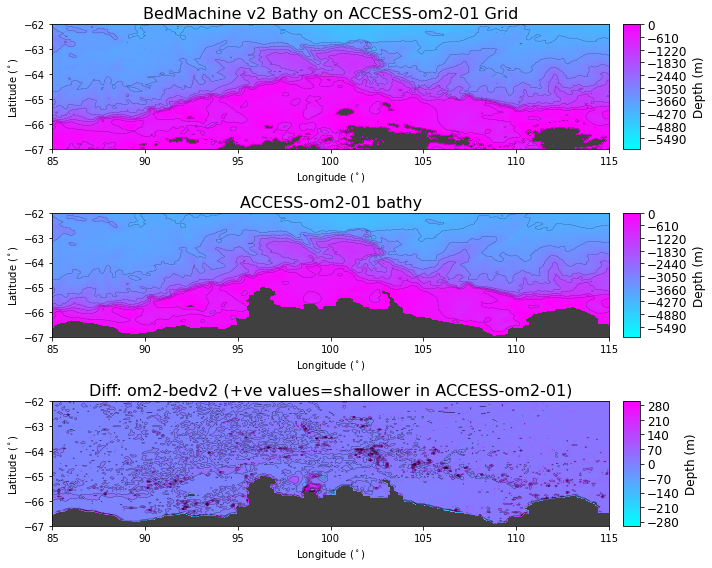

In [43]:
#np.nanmax(ht.values)
clev = np.arange(-6000,10,10)
clev2 = np.arange(-6000,500,500)
fontsize=12

plt.figure(figsize=(10,8))

plt.subplot(3,1,1)
plt.gca().patch.set_color('.25')
#p1=plt.pcolormesh(ht.xt_ocean,ht.yt_ocean,ht,vmin=0, vmax=6000,cmap=plt.cm.cool)
p1=plt.contourf(bb.xt_ocean,bb.yt_ocean,bb,levels=clev,cmap=plt.cm.cool)
plt.contour(bb.xt_ocean,bb.yt_ocean,bb,levels=clev2,colors='k',linewidths=0.25)
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.ylim([-67,-62])
plt.xlim([85,115])
plt.title('BedMachine v2 Bathy on ACCESS-om2-01 Grid',fontsize = 16)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Depth (m)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)


plt.subplot(3,1,2)
plt.gca().patch.set_color('.25')
#p1=plt.pcolormesh(ht.xt_ocean,ht.yt_ocean,ht,vmin=0, vmax=1500,cmap=plt.cm.cool)
p1=plt.contourf(ht.xt_ocean,ht.yt_ocean,-ht,levels=clev,cmap=plt.cm.cool)
plt.contour(ht.xt_ocean,ht.yt_ocean,-ht,levels=clev2,colors='k',linewidths=0.25)
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.ylim([-67,-62])
plt.xlim([85,115])
plt.title('ACCESS-om2-01 bathy',fontsize = 16)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Depth (m)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

clev = np.arange(-300,310,10)
clev2 = np.arange(-300,350,50)

plt.subplot(3,1,3)
plt.gca().patch.set_color('.25')
#p1=plt.pcolormesh(ht.xt_ocean,ht.yt_ocean,ht,vmin=0, vmax=1500,cmap=plt.cm.cool)
p1=plt.contourf(var.xt_ocean,var.yt_ocean,var,levels=clev,cmap=plt.cm.cool)
plt.contour(var.xt_ocean,var.yt_ocean,var,levels=clev2,colors='k',linewidths=0.25)
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.ylim([-67,-62])
plt.xlim([85,115])
plt.title('Diff: om2-bedv2 (+ve values=shallower in ACCESS-om2-01)',fontsize = 16)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Depth (m)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)


plt.tight_layout()

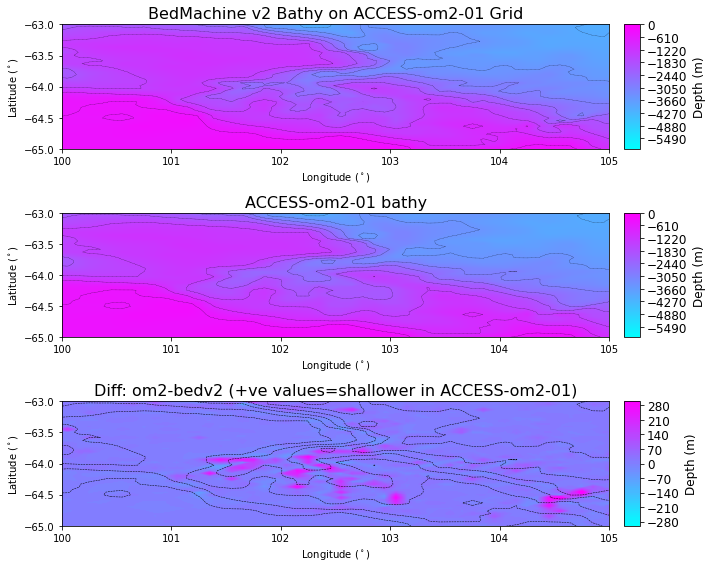

In [45]:
#np.nanmax(ht.values)
clev = np.arange(-6000,10,10)
clev2 = np.arange(-6000,500,500)
fontsize=12

plt.figure(figsize=(10,8))

plt.subplot(3,1,1)
plt.gca().patch.set_color('.25')
#p1=plt.pcolormesh(ht.xt_ocean,ht.yt_ocean,ht,vmin=0, vmax=6000,cmap=plt.cm.cool)
p1=plt.contourf(bb.xt_ocean,bb.yt_ocean,bb,levels=clev,cmap=plt.cm.cool)
plt.contour(bb.xt_ocean,bb.yt_ocean,bb,levels=clev2,colors='k',linewidths=0.25)
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.ylim([-65,-63])
plt.xlim([100,105])
plt.title('BedMachine v2 Bathy on ACCESS-om2-01 Grid',fontsize = 16)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Depth (m)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)


plt.subplot(3,1,2)
plt.gca().patch.set_color('.25')
#p1=plt.pcolormesh(ht.xt_ocean,ht.yt_ocean,ht,vmin=0, vmax=1500,cmap=plt.cm.cool)
p1=plt.contourf(ht.xt_ocean,ht.yt_ocean,-ht,levels=clev,cmap=plt.cm.cool)
plt.contour(ht.xt_ocean,ht.yt_ocean,-ht,levels=clev2,colors='k',linewidths=0.25)
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.ylim([-65,-63])
plt.xlim([100,105])
plt.title('ACCESS-om2-01 bathy',fontsize = 16)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Depth (m)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

clev = np.arange(-300,310,10)
clev2 = np.arange(-6000,500,500)

plt.subplot(3,1,3)
plt.gca().patch.set_color('.25')
#p1=plt.pcolormesh(ht.xt_ocean,ht.yt_ocean,ht,vmin=0, vmax=1500,cmap=plt.cm.cool)
p1=plt.contourf(var.xt_ocean,var.yt_ocean,var,levels=clev,cmap=plt.cm.cool)
plt.contour(ht.xt_ocean,ht.yt_ocean,-ht,levels=clev2,colors='k',linewidths=0.5)
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.ylim([-65,-63])
plt.xlim([100,105])
plt.title('Diff: om2-bedv2 (+ve values=shallower in ACCESS-om2-01)',fontsize = 16)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Depth (m)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()